In [41]:
import numpy as np
import keras
import scipy
import os
from IPython.display import Audio
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import random
import pylab
import wave
import sounddevice as sd
import scipy.io.wavfile as wavf

OUTPUT_DIR = "data/synthesized"
VOICE_MS = 1500
SAMPLE_MS = 10000
STRIDE = 4
FILTER_SIZE = 15

In [2]:
data_dir = os.walk("data/background")
for i in data_dir:
    folders = i[1]
    break
background_noise_files = []
files = []
for i in folders:
    folder_path = os.path.join("data/background", i)
    for f in os.listdir(folder_path):
        files.append(os.path.join(folder_path, f))

In [7]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    print(frame_rate)
    x = pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
    return x[0]
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [8]:
def get_random_startpoint_in_clip(clip):
    clip_length = len(clip)
    start_point = random.randint(0, clip_length - 10 * 1000)
    return start_point

def create_random_audio(audio_files, file_name):
    file_id = random.randint(0, len(audio_files))
    
    background_noise = AudioSegment.from_wav(files[file_id])
    background_noise = background_noise.set_frame_rate(44100)
    start_point = get_random_startpoint_in_clip(background_noise)
    
    background_noise[start_point: start_point + (10 * 1000)].export(file_name, format="wav")
    return AudioSegment.from_file(file_name)
create_random_audio(files, "data/test.wav")
Audio("data/test.wav")

/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


44100
866


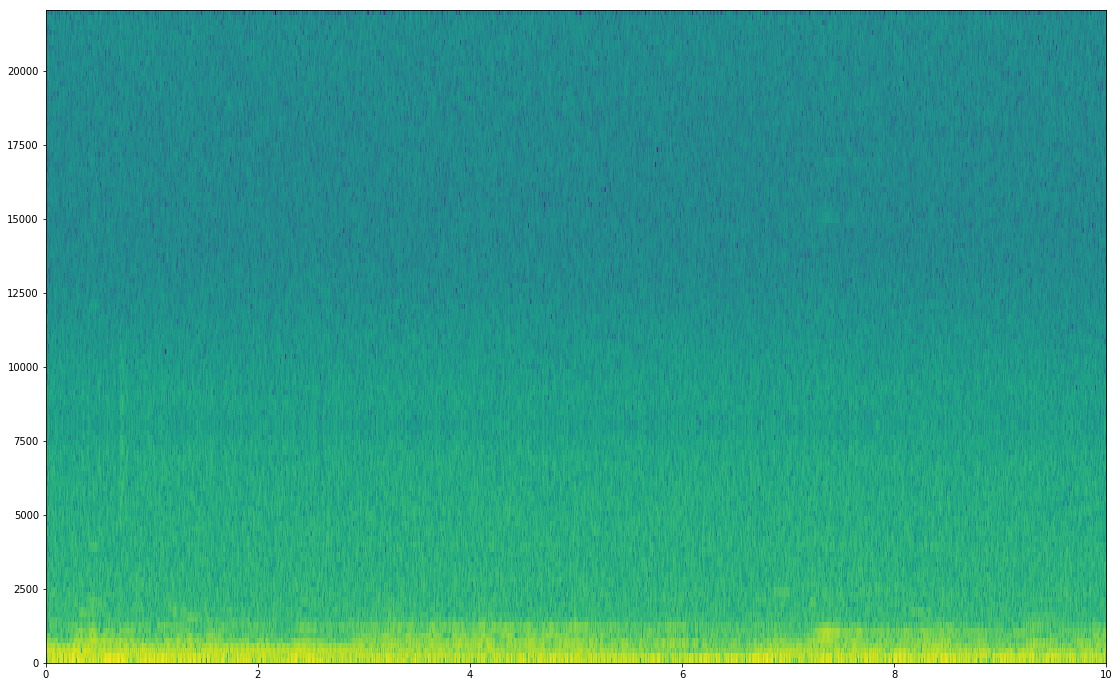

In [46]:
spec = graph_spectrogram("data/test.wav")
FREQS, SPEC_SIZE = np.shape(spec)

OUTPUT_LENGTH = round(((SPEC_SIZE + FILTER_SIZE) / STRIDE) + 1)
print(OUTPUT_LENGTH)


In [47]:
def record_sound(filename):
    duration = 1.5  # seconds
    fs = 44100
    myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=2, blocking=True)
    wavf.write(filename, fs, myrecording)
    return myrecording


In [48]:


#record_sound("data/voices/neg%d.wav" % i)


In [49]:
pos_voices = [f for f in os.listdir("data/voices/pos/")]
neg_voices = [f for f in os.listdir("data/voices/neg/")]
def get_random_voice(positive_sample):
    pos_voice_index = random.randint(3, len(pos_voices))
    neg_voice_index = random.randint(1, len(neg_voices))
    path = "data/voices/pos/pos%s.wav" % pos_voice_index if positive_sample else "data/voices/neg/neg%s.wav" % neg_voice_index
    voice = AudioSegment.from_file(path)
    voice = voice[200:]
    return voice

5700
1390
7913
4058


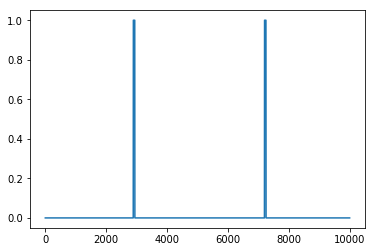

In [74]:
def is_overlap(position, prev_positions):
    pos_start = position
    pos_stop = position + VOICE_MS
    for p in prev_positions:
        prev_start = p
        prev_stop = p + VOICE_MS
        if pos_start < prev_stop and pos_start > prev_start or pos_stop > prev_start and pos_stop < prev_stop:
            return True
    return False
prev_positions = []
def add_voice_to_background(file_name, background_noise, positive):
    start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    while is_overlap(start_position, prev_positions):
        start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    print(start_position)
    prev_positions.append(start_position)
    voice = get_random_voice(positive)
    res = background_noise.overlay(voice, position=start_position)
    res.export(file_name, format="wav")
    return (res, (start_position + VOICE_MS))


def create_training_sample(file_name):
    y = np.zeros(SAMPLE_MS)
    background_noise = create_random_audio(files, "data/test.wav")
    for i in range(2):
        background_noise, ends = add_voice_to_background(file_name, background_noise, True)
        tends = min(SAMPLE_MS, ends+50)
        y[ends:tends] = 1
        #print(ends)
    for i in range(2):
        background_noise, ends = add_voice_to_background(file_name, background_noise, False)
        #print(ends)
    plt.plot(y)
create_training_sample("data/test_overlay.wav")
Audio("data/test_overlay.wav")

5700
5700
4058
4058
1390
7913
7913
7913
4058
7913
7913
5700
4058
5700
7913
5700
1390
7913
1390
5700
7913
5700
1390
5700
4058
5700
1390
4058
7913
4058
1390
5700
5700
4058
7913
4058
4058
4058
5700
1390


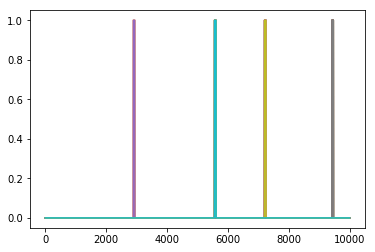

In [75]:
for i in range(10):
    create_training_sample("data/training/x%d.wav" % i)

In [52]:
print(ar)

[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
